# Neural Network with PyTorch: Advanced Concepts

## Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Load and Split the Dataset

We’ll use the MNIST dataset, splitting it into training and validation sets.

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the dataset
dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 66.0kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.60MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Define the Neural Network with Dropout
We include a dropout layer to reduce overfitting.

In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with a 50% dropout rate

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)     # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)         # Output logits
        return x


## Set Hyperparameters and Initialize Model
Here, we initialize the model, loss function, optimizer, and define some hyperparameters.

In [4]:
# Initialize model, loss function, and optimizer
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
num_epochs = 50
early_stopping_patience = 5  # For early stopping


## Implement Early Stopping
Define a helper function to monitor validation loss and stop training when performance ceases to improve.

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf

    def should_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopping = EarlyStopping(patience=early_stopping_patience)


## Train the Model with Validation and Early Stopping
Track training and validation loss for visualization and apply early stopping.

In [6]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping check
    if early_stopping.should_stop(val_loss):
        print("Early stopping triggered")
        break


Epoch 1/50, Training Loss: 0.5168, Validation Loss: 0.2452
Epoch 2/50, Training Loss: 0.3053, Validation Loss: 0.1931
Epoch 3/50, Training Loss: 0.2670, Validation Loss: 0.1895
Epoch 4/50, Training Loss: 0.2335, Validation Loss: 0.1601
Epoch 5/50, Training Loss: 0.2179, Validation Loss: 0.1365
Epoch 6/50, Training Loss: 0.2060, Validation Loss: 0.1320
Epoch 7/50, Training Loss: 0.1918, Validation Loss: 0.1328
Epoch 8/50, Training Loss: 0.1846, Validation Loss: 0.1224
Epoch 9/50, Training Loss: 0.1786, Validation Loss: 0.1260
Epoch 10/50, Training Loss: 0.1721, Validation Loss: 0.1224
Epoch 11/50, Training Loss: 0.1662, Validation Loss: 0.1157
Epoch 12/50, Training Loss: 0.1595, Validation Loss: 0.1140
Epoch 13/50, Training Loss: 0.1566, Validation Loss: 0.1121
Epoch 14/50, Training Loss: 0.1557, Validation Loss: 0.1028
Epoch 15/50, Training Loss: 0.1512, Validation Loss: 0.1148
Epoch 16/50, Training Loss: 0.1471, Validation Loss: 0.1022
Epoch 17/50, Training Loss: 0.1440, Validation Lo

## Plot Training and Validation Loss Curve
Visualize loss curves to assess the model’s training behavior and check for overfitting or underfitting.

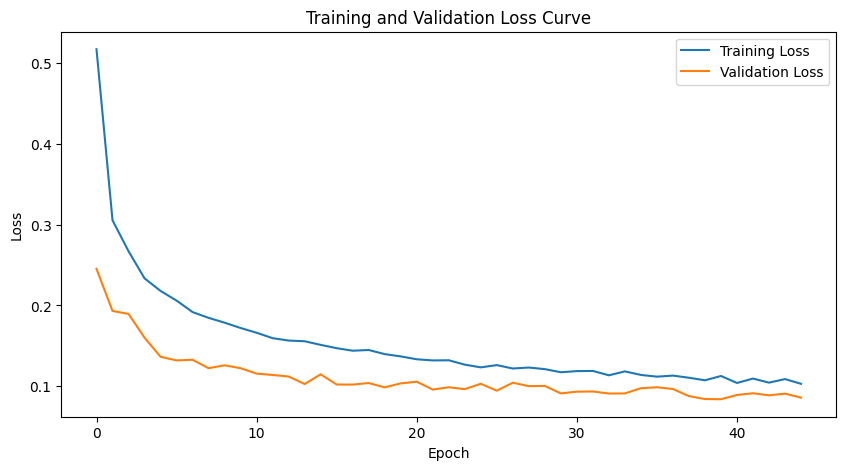

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curve')
plt.show()


**Discussion on Overfitting and Underfitting**
* **Overfitting:** If training loss keeps decreasing while validation loss starts increasing, the model is overfitting.
* **Underfitting:** If both training and validation loss are high and do not decrease, the model is underfitting.

## Evaluate the Model and Make Predictions
Evaluate accuracy on test data and make predictions.

Accuracy on test set: 97.99%


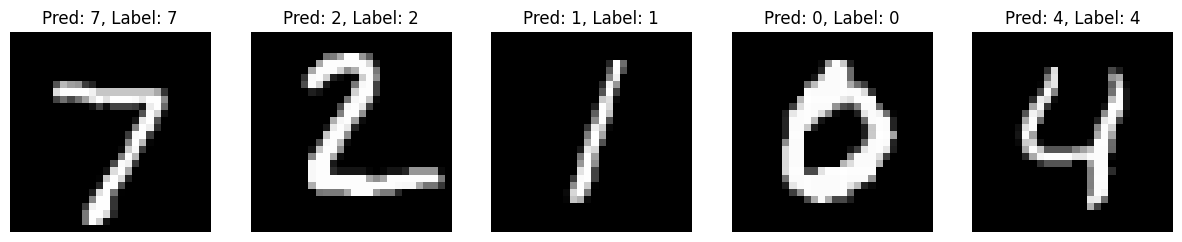

In [8]:
# Load test dataset
test_dataset = datasets.MNIST(root='data', train=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

# Show a few prediction results
import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot the results
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i].view(28, 28).numpy(), cmap='gray')
    ax.set_title(f'Pred: {preds[i].item()}, Label: {labels[i].item()}')
    ax.axis('off')
plt.show()


## Summary
In this notebook, we covered:

* **Model Definition with Dropout:** Building a neural network with dropout to prevent overfitting.
* **Early Stopping:** Implementing early stopping to halt training when validation loss stops improving.
* **Loss Curve Visualization:** Plotting training and validation loss curves to analyze model performance.
* **Overfitting vs Underfitting:** Discussing signs of overfitting and underfitting based on loss curves.
* **Evaluation and Prediction:** Testing the model's accuracy and showing predictions with a few examples.